# Ejercicio 3

En este notebook se probará el caso donde se tiene un umbral difuso, a modo de ver qué es lo que ocurre con el método de Monte Carlo y el método desarrollado en los ejercicios anteriores.

Para ello, se tomará el código creado anteriormente y se realizarán modificaciones para agregar una probabilidad de falla al umbral, donde se tiene que a medida que se avanza hacia el umbral, la probabilidad de falla aumenta de acuerdo a la probabilidad acumulada de una normal centrada en el umbral.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, bernoulli
import scipy.integrate as integrate
import time

In [2]:
# creacion de histogramas
def histograma(hist, bins, alpha=1, color=None, label=''):
    X = np.linspace(0, len(hist), num=bins + 1)
    result = np.zeros(X.shape)
    j = 0
    l = 0
    for i, h in enumerate(hist):
        if i > X[j]:
            result[j] = np.sum(hist[l:i])
            l = i
            j += 1
    plt.bar(X, result, width=len(hist)/bins + 1, alpha=alpha, color=color, label=label)
    return [X, result]
            

In [3]:
def resamplear(xk, wk, k):
    wk = wk + (1 - np.sum(wk)) / len(wk)
    ns = len(wk)
#     print(np.sum(wk))
    idx = np.random.choice(range(0, ns), k, p=wk)
    xk = xk[idx]
    wk = np.ones((ns,)) * (1/ns)
    return [xk, wk, idx]

In [26]:
def KL_dist(p, q):
    eps = 1e-9
    p = p + eps
    q = q + eps
    
    if len(q) != len(p): raise ValueError('the number of columns in p and q must be the same!')
    if np.sum(p) > 1.1 or np.sum(q) > 1.1: raise ValueError('the sum of the vectors must be equal or less than 1')
    
    kl_dist = p * np.log(p/q)
    kl_dist[[math.isnan(j) for j in kl_dist]] = 0
    kl_dist = np.sum(kl_dist)
    
    return kl_dist

Elapsed time: 14.7601s
0.998411 1000000


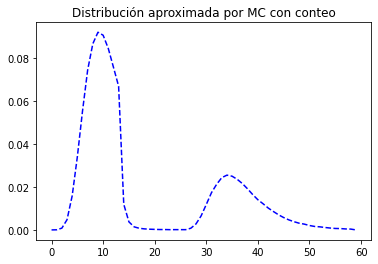

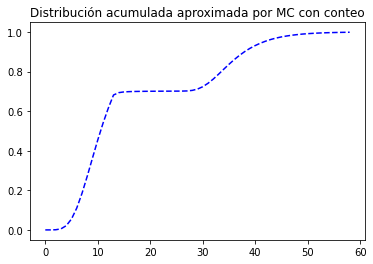

Graficos Elapsed time: 0.3004s


In [4]:
# primero se crea el proceso

x_0 = 1
N = 60

proceso = np.zeros((N,))
proceso[0] = x_0
a1 = 1.01
b1 = 0.75
sigma = 0.5
np.random.seed(32)
u = 5
sigma_u = 0.8
K = 0.3

# definicion de las iteraciones de MC
M = 1000000
PROCESOS = np.zeros((N,M))
PROCESOS[0, :] = x_0
np.random.seed(42)

cuentas = np.zeros((M,))
histogram_MC = np.zeros((N,))
acumulada = np.zeros((N - 1,))

I, J = [13, 26]

# media y varianza analiticas
E = np.zeros((N,))
Var = np.zeros((N,))

E[0] = proceso[0]


start = time.time()
for i in range(I):
    proceso[i + 1] = K + a1 * proceso[i] + np.random.normal(0, sigma)
    PROCESOS[i + 1, :] = K + a1 * PROCESOS[i,:] + np.random.normal(0, sigma, size=(M,))
    
    # en este paso hay que calcular la probabilidad de que falle por solo estar cerca del umbral
    # hay que sacar la cdf de una normal centrada en el umbral
    p = norm.cdf(PROCESOS[i, :], loc=u, scale=sigma_u)
    d = bernoulli.rvs(p)

    anterior = np.sum(cuentas)
    checkeo = d == 1
    cuentas[checkeo] = 1
    
    histogram_MC[i] = np.sum(cuentas) - anterior
    acumulada[i] = acumulada[i - 1] + histogram_MC[i]
    
    # media y varianza
    E[i + 1] = K + a1 * E[i]
    Var[i + 1] = a1 ** 2 * Var[i] + sigma**2
    

for i in range(I, J):
    proceso[i + 1] = K + a1 * b1 * proceso[i] + np.random.normal(0, sigma)
    PROCESOS[i + 1, :] = K + a1 * b1 * PROCESOS[i,:] + np.random.normal(0, sigma, size=(M,))
    
    p = norm.cdf(PROCESOS[i, :], loc=u, scale=sigma_u)
    d = bernoulli.rvs(p)

    anterior = np.sum(cuentas)
    # sobre el umbral
    checkeo = d == 1
    cuentas[checkeo] = 1
    
    histogram_MC[i] = np.sum(cuentas) - anterior
    acumulada[i] = acumulada[i - 1] + histogram_MC[i]
    
    # media y varianza
    E[i + 1] = K + a1 * b1 * E[i]
    Var[i + 1] = a1 ** 2 * b1 ** 2 * Var[i] + sigma**2

for i in range(J, int((N-1))):
    proceso[i + 1] = K + a1 * proceso[i] + np.random.normal(0, sigma)
    PROCESOS[i + 1, :] = K + a1 * PROCESOS[i,:] + np.random.normal(0, sigma, size=(M,))
    
    p = norm.cdf(PROCESOS[i, :], loc=u, scale=sigma_u)
    d = bernoulli.rvs(p)

    anterior = np.sum(cuentas)
    # sobre el umbral
    checkeo = d == 1
    cuentas[checkeo] = 1
    
    histogram_MC[i] = np.sum(cuentas) - anterior
    acumulada[i] = acumulada[i - 1] + histogram_MC[i]
    
    # media y varianza
    E[i + 1] = K + a1 * E[i]
    Var[i + 1] = a1 ** 2 * Var[i] + sigma**2
    
end = time.time()
print('Elapsed time: {:.4f}s'.format(end - start))

start = time.time()
histogram_MC = histogram_MC / M
# plt.plot(PROCESOS, color='k', alpha=0.05)
# plt.plot(proceso, color='r', lw=3)
# plt.plot(E, color='g', lw=5)
# plt.plot(E - np.sqrt(Var), color='g', lw=5, alpha=0.5)
# plt.plot(E + np.sqrt(Var), color='g', lw=5, alpha=0.5)
# plt.hlines(u,0,N)
# plt.ylim(top=u*1.4, bottom=0)

# # pintar zona de peligro
# zona_peligro = np.linspace(u - 3 * sigma_u, u + 3 * sigma_u, num=50)
# prob_zona_peligro = norm.cdf(zona_peligro, loc=u, scale=sigma_u)
# for i, z in enumerate(zona_peligro):
# #     print(i, z, prob_zona_peligro[i])
#     plt.hlines(z, 0, N, alpha=np.min((prob_zona_peligro[i], 1)), color='b')

# plt.title('Simulaciones con Monte Carlo del proceso $a_1={}, b_1={}, k={}, \sigma={}$'.format(a1,b1,K,sigma))
# plt.show()

print(np.sum(histogram_MC), M)
plt.plot(histogram_MC, label='MC', color='b', linestyle='dashed')
plt.title('Distribución aproximada por MC con conteo')
plt.show()

plt.plot(acumulada / M, label='MC', color='b', linestyle='dashed')
plt.title('Distribución acumulada aproximada por MC con conteo')
plt.show()


end = time.time()
print('Graficos Elapsed time: {:.4f}s'.format(end - start))


A continuación se aplicará el método del ejercicio 2 basado en el filtro de partículas para calcular la PMF del instante de falla, considerando el umbral difuso

Elapsed time: 1.1031s
0.9975 400


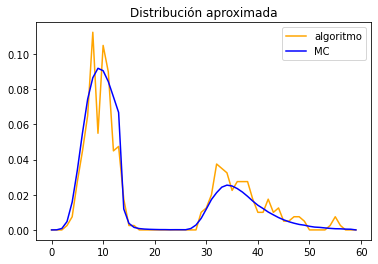

Dist KL: 0.24457532832997245


In [21]:
# se toma el instante inicial
k = 0
m = 400 # cantidad de particulasnumpy 
particulas = np.zeros((N,m))
particulas[k,:] = np.random.normal(E[k], np.sqrt(Var[k]), size=m)
# particulas[k,:] = E[k]

cuentas2 = np.zeros((m,))
histogram_filtro = np.zeros((N,))
anterior = 0
total = 0
indices_bajo_umbral = np.arange(0,N)

# paso de propagacion de las particulas

start = time.time()
for i in range(k, I):    
    anterior = total
    for j, p in enumerate(particulas[i, :]):
        if cuentas2[j] == 0.0 and bernoulli.rvs(norm.cdf(p, loc=u, scale=sigma_u)):
            total += 1
            cuentas2[j] = i
            
    histogram_filtro[i] = (total - anterior) / (m)
    
    particulas[i + 1, :] = K + a1 * particulas[i,:] + np.random.normal(0, sigma, size=m)

for i in range(I, J):
    anterior = total
    for j, p in enumerate(particulas[i, :]):
        if cuentas2[j] == 0.0 and bernoulli.rvs(norm.cdf(p, loc=u, scale=sigma_u)):
            total += 1
            cuentas2[j] = i
            
    histogram_filtro[i] = (total - anterior) / (m)
    
    particulas[i + 1, :] = K + a1 * b1 * particulas[i,:] + np.random.normal(0, sigma, size=m)

for i in range(J, int((N-1))):    
    anterior = total
    for j, p in enumerate(particulas[i, :]):
        if cuentas2[j] == 0.0 and bernoulli.rvs(norm.cdf(p, loc=u, scale=sigma_u)):
            total += 1
            cuentas2[j] = i
            
    histogram_filtro[i] = (total - anterior) / (m)
    
    particulas[i + 1, :] = K + a1 * particulas[i,:] + np.random.normal(0, sigma, size=m)
    
end = time.time()
print('Elapsed time: {:.4f}s'.format(end - start))

print(np.sum(histogram_filtro), m)
plt.plot(histogram_filtro, label='algoritmo', color='orange')
plt.plot(histogram_MC, label='MC', color='b')
plt.title('Distribución aproximada')
plt.legend()
plt.show()

print('Dist KL: {}'.format(KL_dist(histogram_MC, histogram_filtro)))

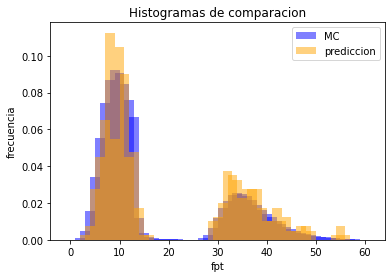

In [22]:
x, h = histograma(histogram_MC, bins=len(histogram_MC), alpha=0.5, color='b', label='MC')
x, h = histograma(histogram_filtro, bins=len(histogram_filtro), alpha=0.5, color='orange', label='prediccion')
# plt.plot(histogram_filtro, label='prediccion', color='orange')
# plt.plot(histogram_MC, label='MC', color='b')
plt.legend()
plt.xlabel('fpt')
plt.ylabel('frecuencia')
plt.title('Histogramas de comparacion')
plt.show()


Elapsed time: 1.0279s
0.9974999999999999 400


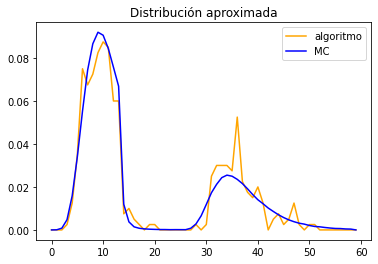

Dist KL: 0.44443645615986976


In [23]:
# se toma el instante inicial
k = 0
m = 400 # cantidad de particulasnumpy 
particulas = np.zeros((N,m))
particulas[k,:] = np.random.normal(E[k], np.sqrt(Var[k]), size=m)
# particulas[k,:] = E[k]

cuentas2 = np.zeros((m,))
histogram_filtro = np.zeros((N,))
anterior = 0
total = 0
indices_bajo_umbral = np.arange(0,N)

# paso de propagacion de las particulas

start = time.time()
for i in range(k, I):    
    anterior = total
    for j, p in enumerate(particulas[i, :]):
        if cuentas2[j] == 0.0 and bernoulli.rvs(norm.cdf(p, loc=u, scale=sigma_u)):
            total += 1
            cuentas2[j] = i
            
    histogram_filtro[i] = (total - anterior) / (m)
    
    particulas[i + 1, :] = K + a1 * particulas[i,:] + np.random.normal(0, sigma, size=m)

for i in range(I, J):
    anterior = total
    for j, p in enumerate(particulas[i, :]):
        if cuentas2[j] == 0.0 and bernoulli.rvs(norm.cdf(p, loc=u, scale=sigma_u)):
            total += 1
            cuentas2[j] = i
            
    histogram_filtro[i] = (total - anterior) / (m)
    
    particulas[i + 1, :] = K + a1 * b1 * particulas[i,:] + np.random.normal(0, sigma, size=m)

for i in range(J, int((N-1))):    
    anterior = total
    for j, p in enumerate(particulas[i, :]):
        if cuentas2[j] == 0.0 and bernoulli.rvs(norm.cdf(p, loc=u, scale=sigma_u)):
            total += 1
            cuentas2[j] = i
            
    histogram_filtro[i] = (total - anterior) / (m)
    
    particulas[i + 1, :] = K + a1 * particulas[i,:] + np.random.normal(0, sigma, size=m)
    
end = time.time()
print('Elapsed time: {:.4f}s'.format(end - start))

print(np.sum(histogram_filtro), m)
plt.plot(histogram_filtro, label='algoritmo', color='orange')
plt.plot(histogram_MC, label='MC', color='b')
plt.title('Distribución aproximada')
plt.legend()
plt.show()

print('Dist KL: {}'.format(KL_dist(histogram_MC, histogram_filtro)))

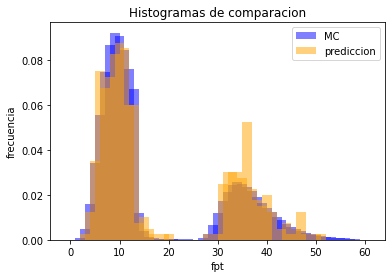

In [24]:
x, h = histograma(histogram_MC, bins=len(histogram_MC), alpha=0.5, color='b', label='MC')
x, h = histograma(histogram_filtro, bins=len(histogram_filtro), alpha=0.5, color='orange', label='prediccion')
# plt.plot(histogram_filtro, label='prediccion', color='orange')
# plt.plot(histogram_MC, label='MC', color='b')
plt.legend()
plt.xlabel('fpt')
plt.ylabel('frecuencia')
plt.title('Histogramas de comparacion')
plt.show()


Elapsed time: 0.0527s
0.9974815965539126 400


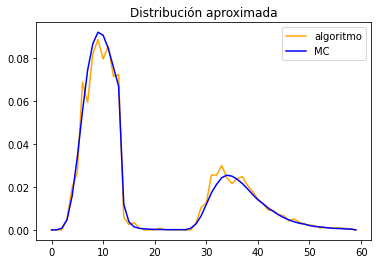

Dist KL: 0.05564609103682128


In [25]:
# se toma el instante inicial
k = 0
m = 400 # cantidad de particulasnumpy 
particulas = np.random.normal(E[k], np.sqrt(Var[k]), size=m)
pesos = np.ones((m,)) / m

cuentas2 = np.zeros((m,))
histogram_filtro = np.zeros((N,))
anterior = 0
total = 0
indices_bajo_umbral = np.arange(0,N)

# paso de propagacion de las particulas
start = time.time()
for i in range(k, I):

    # particulas sobre el umbral
    idx = np.argsort(particulas)
    particulas = particulas[idx]
    pesos = pesos[idx]
    
    p_th_i = np.argwhere(particulas >= u - 3*sigma_u)
    
    if len(p_th_i) == 0:
        p_th = p_th_i
    else:
        p = norm.cdf(particulas[p_th_i], loc=u, scale=sigma_u)
        b = bernoulli.rvs(p)
        p_th = p_th_i[b > 0]
    
    if len(p_th) > 0:
        histogram_filtro[i] = np.sum(pesos[p_th])
        n_np = np.sum(pesos[p_th] != 0)
        pesos[p_th] = 0
        p_u_th = particulas[pesos != 0]
        w_u_th = pesos[pesos != 0]
        
        if len(w_u_th) > 0:
            p_new, _, _  = resamplear(p_u_th, w_u_th, n_np)
            particulas = np.concatenate((p_new, particulas))
            w_aux = np.ones((len(p_new),)) * np.sum(w_u_th) / m
            pesos[pesos != 0] = np.sum(w_u_th) / m
            pesos = np.concatenate((w_aux, pesos))
            
    particulas = K + a1 * particulas + np.random.normal(0, sigma, size=len(particulas))

for i in range(I, J):

    # particulas sobre el umbral
    idx = np.argsort(particulas)
    particulas = particulas[idx]
    pesos = pesos[idx]
    
    p_th_i = np.argwhere(particulas >= u - 3*sigma_u)
    
    if len(p_th_i) == 0:
        p_th = p_th_i
    else:
        p = norm.cdf(particulas[p_th_i], loc=u, scale=sigma_u)
        b = bernoulli.rvs(p)
        p_th = p_th_i[b > 0]
    
    if len(p_th) > 0:
        histogram_filtro[i] = np.sum(pesos[p_th])
        n_np = np.sum(pesos[p_th] != 0)
        pesos[p_th] = 0
        p_u_th = particulas[pesos != 0]
        w_u_th = pesos[pesos != 0]
        
        if len(w_u_th) > 0:
            p_new, _, _  = resamplear(p_u_th, w_u_th, n_np)
            particulas = np.concatenate((p_new, particulas))
            w_aux = np.ones((len(p_new),)) * np.sum(w_u_th) / m
            pesos[pesos != 0] = np.sum(w_u_th) / m
            pesos = np.concatenate((w_aux, pesos))
            
    particulas = K + a1 * b1 * particulas + np.random.normal(0, sigma, size=len(particulas))

for i in range(J, int((N-1))):    

    # particulas sobre el umbral
    idx = np.argsort(particulas)
    particulas = particulas[idx]
    pesos = pesos[idx]
    
    p_th_i = np.argwhere(particulas >= u - 3*sigma_u)
    
    if len(p_th_i) == 0:
        p_th = p_th_i
    else:
        p = norm.cdf(particulas[p_th_i], loc=u, scale=sigma_u)
        b = bernoulli.rvs(p)
        p_th = p_th_i[b > 0]
        
    if len(p_th) > 0:
        histogram_filtro[i] = np.sum(pesos[p_th])
        n_np = np.sum(pesos[p_th] != 0)
        pesos[p_th] = 0
        p_u_th = particulas[pesos != 0]
        w_u_th = pesos[pesos != 0]
        
        if len(w_u_th) > 0:
            p_new, _, _  = resamplear(p_u_th, w_u_th, n_np)
            particulas = np.concatenate((p_new, particulas))
            w_aux = np.ones((len(p_new),)) * np.sum(w_u_th) / m
            pesos[pesos != 0] = np.sum(w_u_th) / m
            pesos = np.concatenate((w_aux, pesos))

    particulas = K + a1 * particulas + np.random.normal(0, sigma, size=len(particulas))
    
end = time.time()
print('Elapsed time: {:.4f}s'.format(end - start))

print(np.sum(histogram_filtro), m)
plt.plot(histogram_filtro, label='algoritmo', color='orange')
plt.plot(histogram_MC, label='MC', color='b')
plt.title('Distribución aproximada')
plt.legend()
plt.show()

print('Dist KL: {}'.format(KL_dist(histogram_MC, histogram_filtro)))